In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')
import sys
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt 
from tensorflow import keras
from keras import layers
from tensorflow.keras.optimizers import Adam
import random    
import sklearn
tf.keras.backend.set_floatx('float64')
import keras.backend as K
from keras.datasets import mnist,cifar10,fashion_mnist
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten,  Conv2DTranspose, MaxPooling2D, UpSampling2D
initializer = tf.keras.initializers.HeNormal(seed=42)
from keras.constraints import UnitNorm
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score,auc,RocCurveDisplay,roc_curve

In [2]:
np.random.seed(42)

In [3]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
#y_train = y_train.flatten()
#y_test=y_test.flatten()
X_train = np.concatenate((x_train[y_train==0],x_train[y_train==8]))
X_test = np.concatenate((x_test[y_test==0],x_test[y_test==8]))
Y_train = np.concatenate((np.ones(len(x_train[y_train==0])),np.ones(len(x_train[y_train==8]))))
Y_test = np.concatenate((np.ones(len(x_test[y_test==0])),np.ones(len(x_test[y_test==8]))))
X_train,Y_train = sklearn.utils.shuffle(X_train,Y_train,random_state=42)
X_test,Y_test = sklearn.utils.shuffle(X_test,Y_test,random_state=42)

In [4]:
train_images, test_images = X_train/ 255.0, X_test / 255.0

x_train_data = np.concatenate((X_train,X_test))
y_train_data = np.concatenate((Y_train,Y_test))
x_train_data.shape,y_train_data.shape

((14000, 28, 28), (14000,))

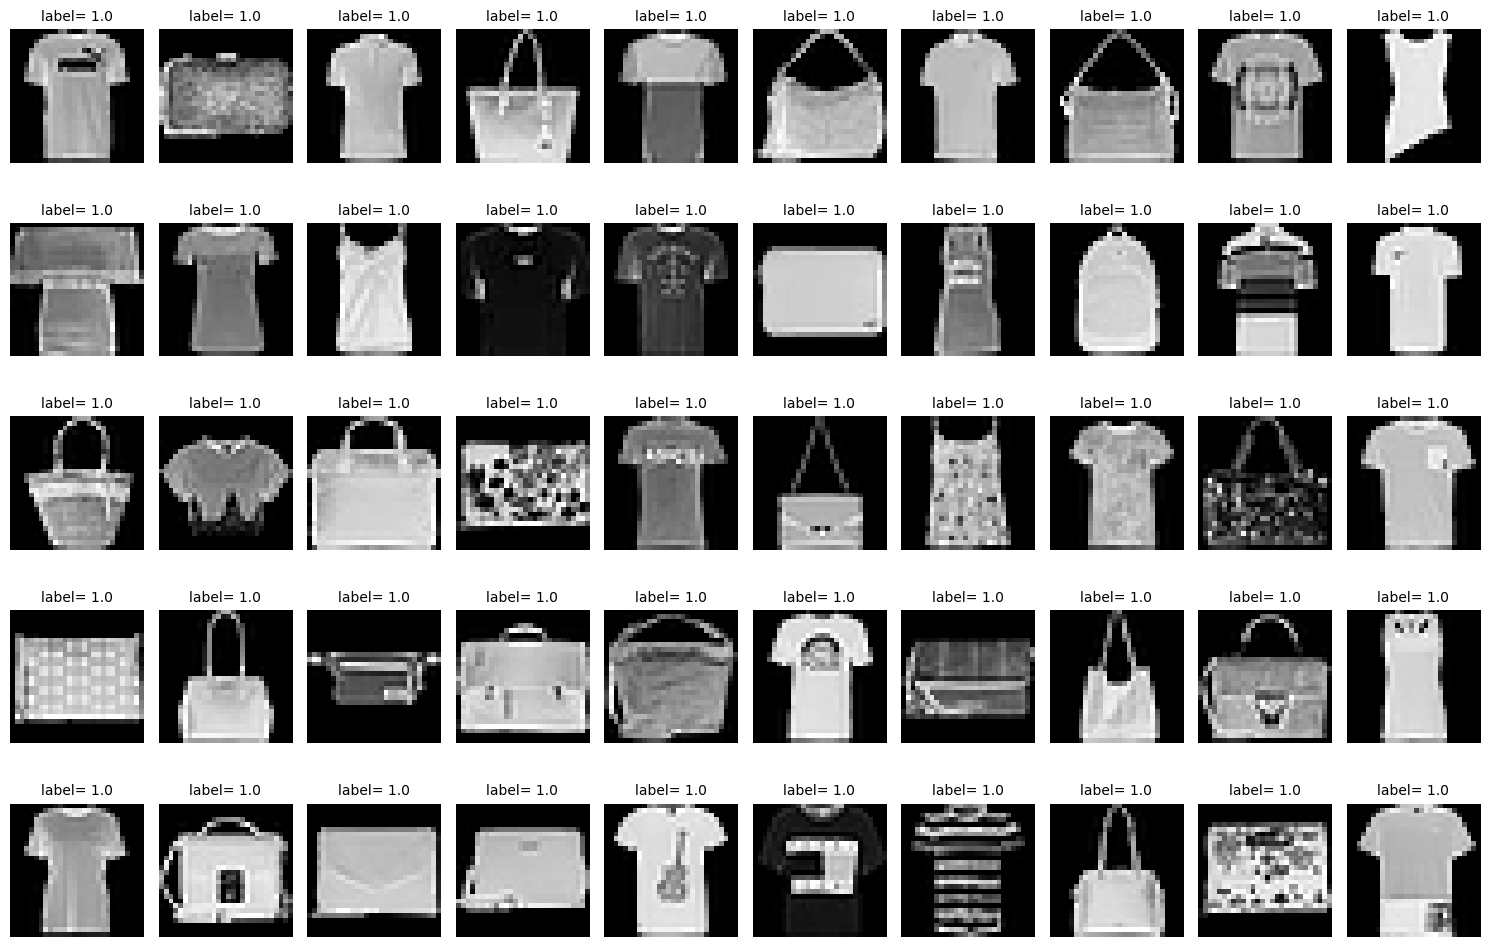

In [5]:
fig = plt.figure(figsize=(15,10))
for i in range(50):
  y = fig.add_subplot(5,10,i+1)
  y.imshow(x_train_data[i],cmap='gray');
  y.set_title('label= {}'.format(y_train_data[i]),fontsize=10)
  y.axis('off')
plt.tight_layout()

In [13]:
qubits = 6
num_layers= 2
#####################################
def embedding_qlayer(x):
    batched = qml.math.ndim(x) > 1
    x = qml.math.T(x) if batched else x
    qml.Rot(x[0],x[1],x[2], wires=1)
    qml.Rot(x[3],x[4],x[5], wires=2)
    qml.Rot(x[6],x[7],x[8], wires=3)

    qml.Rot(x[9],x[10],x[11], wires=4)
    qml.Rot(x[12],x[13],x[14], wires=5)
    qml.Rot(x[15],x[16],x[17], wires=6)


    
    
#####################    
dev = qml.device('default.qubit.tf', wires=qubits+1,shots=None)
@qml.qnode(dev, interface="tf",diff_method='backprop')
def qcircuit(params,inputs):
    for i in range(num_layers): 
        #qml.AngleEmbedding(features=inputs, wires=range(1,qubits+1), rotation='Y')
        #qml.IQPEmbedding(features=inputs[:,:3], wires=[1,2,3])
        #qml.IQPEmbedding(features=inputs[:,3:], wires=[4,5,6])
        qml.StronglyEntanglingLayers(weights=tf.expand_dims(params[i,:,:],0), wires=[1,2,3], imprimitive=qml.ops.CZ)
        qml.StronglyEntanglingLayers(weights=tf.expand_dims(params[i,:,:],0), wires=[4,5,6], imprimitive=qml.ops.CZ)
        embedding_qlayer(inputs)
    qml.Hadamard(wires=0)
    for k in range(3):
        qml.CSWAP(wires=[0, k + 1, qubits/2 + k + 1])
    qml.Hadamard(wires=0)

    return qml.expval(qml.PauliZ(0)) 
    
shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=int(qubits/2))
####################################
#dev1 = qml.device('default.qubit.tf', wires=qubits)
#@qml.qnode(dev1, interface="tf", diff_method="backprop")
#def circuit(params,inputs):
#    for i in range(num_layers): 
#        embedding_qlayer(inputs)
#        qml.BasicEntanglerLayers(weights=tf.expand_dims(params[i,:],0), wires=range(qubits))
#    return qml.density_matrix(wires=0)
#shape1 = qml.BasicEntanglerLayers.shape(n_layers=num_layers, n_wires=qubits)

In [14]:
#@qml.qnode(dev, interface="tf", diff_method="backprop")
#def swap_test(q_weights, x1, x2):

    # load the two inputs into two different registers
#    QAOAEmbedding(features=x1, weights=q_weights, wires=[1, 2])
#    QAOAEmbedding(features=x2, weights=q_weights, wires=[3, 4])

#    # perform the SWAP test
#    qml.Hadamard(wires=0)
#    for k in range(n_features):
#        qml.CSWAP(wires=[0, k + 1, 2 + k + 1])
#    qml.Hadamard(wires=0)

#    return qml.expval(qml.PauliZ(0))

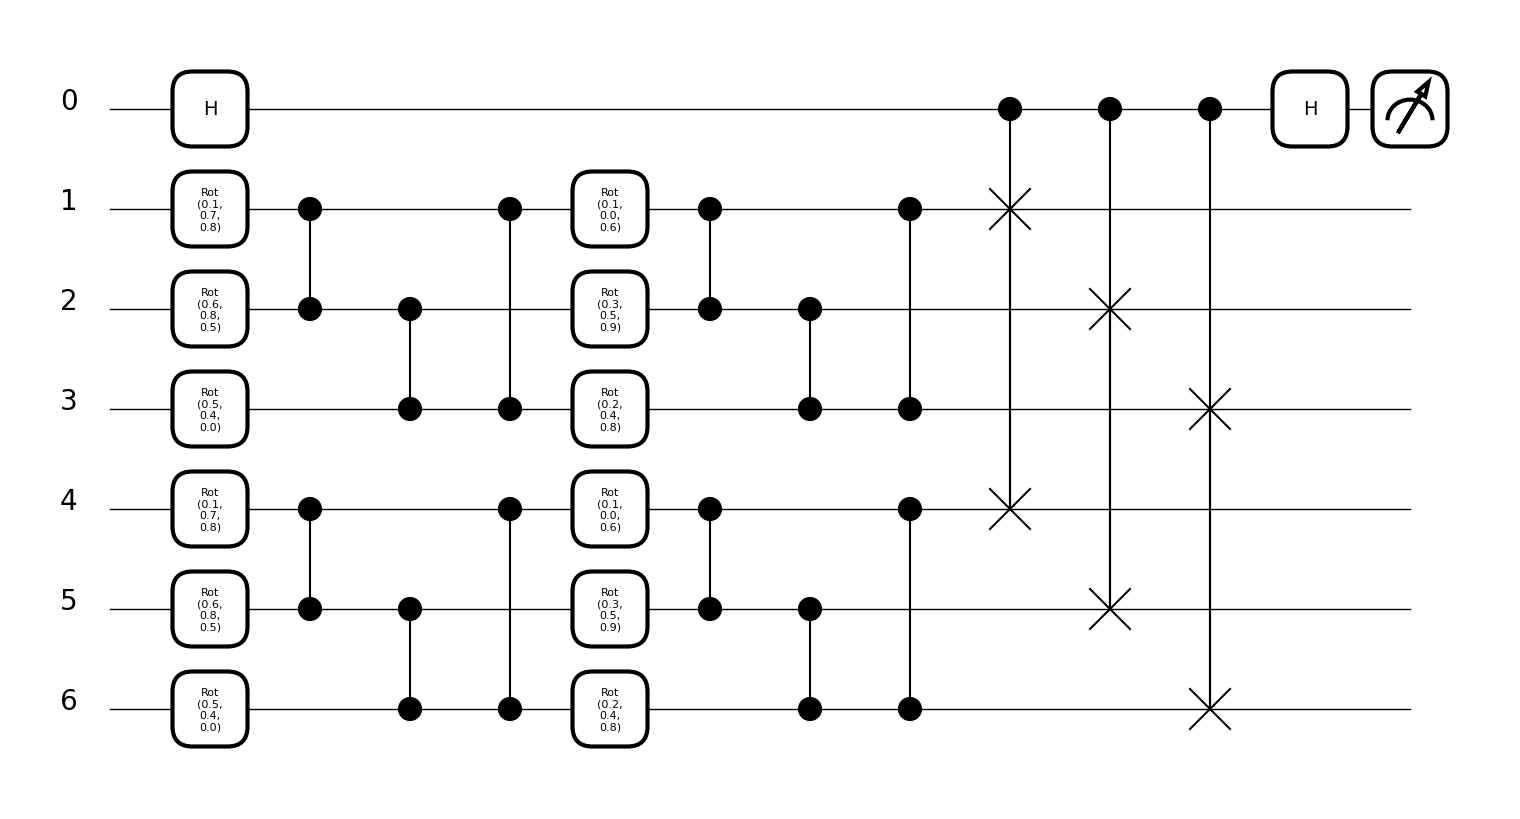

In [15]:
# plot the quanutm layer with strong entanglement
weights = np.random.random(size=shape)
X = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x1','x2','x3','x4','x5','x6','x7','x8','x9']
#X = np.random.rand(18)
qml.draw_mpl(qcircuit,expansion_strategy='device',decimals=1,style='black_white',font_size='xx-large',wire_options={'linewidth': 1},label_options={'size': 20})(weights,X);

In [10]:
## create the quanutm layer
shapes = {"params": qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=int(qubits/2))}
qlayer = qml.qnn.KerasLayer(qcircuit, shapes, output_dim=1,name='Quantum_Layer')

In [11]:
#def Dot(x,y):
#    return [(x[i][0]*y[i][0])+(x[i][1]*y[i][1]) for i in range(len(x))]

#def prepare_state_labels(x):
#    if x == 1: 
#         return (np.array([[0,0],[0,1]]))
#    if x ==0: 
#        return (np.array([[1,0],[0,0]]))

#def prepare_state_labels_HS(x):
#    y=[]
#    for i in x:
#        if i == 1: 
#            y.append(np.array([[0,0],[0,1]]))
#        if i ==0: 
#            y.append(np.array([[1,0],[0,0]]))
#    t1 = tf.cast(tf.constant(y),'complex128')       
#    return t1

#def fedal_cost(x,y):
#    loss = tf.math.sqrt(1-tf.math.abs(Dot(x,prepare_state_labels(y)))**2)
#    return loss

#def HS_dist(vects):
#    x, y = vects
#    tr1 = tf.linalg.trace(tf.math.abs((x)**2))
#    tr2 = tf.linalg.trace(tf.math.abs((y)**2))
#    tr3 = 2*tf.linalg.trace(tf.math.abs((x)*(y)))
#    return  0.5*((tr1+tr2-tr3))
    
def HS_cost(x1,x2,x3,y):
    h_dist =  -2 * x3 + (x1 + x2)
    return y - 0.5*h_dist
    
def fidelity(x,y):
    fedal=[]
    for i in range(len(x)):
        fedal.append(qml.math.fidelity(x[i],prepare_state_labels(y[i])))
    return np.array(fedal)
    
@tf.function
def train_step(cost,x,y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = cost(logits,y)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value


def test(model,xt,yt):
    state0 = np.zeros(len(xt))
    state1 = np.ones(len(xt))
    accu=[]
    yh = model(xt)
    idx = fidelity(yh,state0)-fidelity(yh,state1)
    for i in range(len(idx)):
        if idx[i] < 0:
            accu.append(abs(1-yt[i]))
        elif idx[i] > 0:
            accu.append(abs(0-yt[i]))
        else:
            accu.append(abs(idx[i]-yt[i]))
    accu = np.array(accu)
    return len(accu[accu==0])/len(accu), np.array(idx)   



def make_pairs(x, y):
    pairs = []
    labels = []
    for idx1,idx2 in zip(x,y): 
        pairs += [[idx1, idx2]]
    return np.array(pairs)

In [12]:
pairs_train = make_pairs(train_images[Y_train==0],train_images[Y_train==1]) # pairs should be always from different classes
k_train = 2000
k_test = 10000
k_val =100
#####################
x_train=pairs_train[:k_train]
y_train=np.ones(len(x_train))

x_val=pairs_train[-k_val:]
y_val=np.ones(len(x_val))

x_test=X_test[:1000]
y_test=Y_test[:1000]

#x_test=x_data[k_train:k_train+k_test]
#y_test=y_data[k_train:k_train+k_test]

print(f'''x train shape: {x_train.shape}
x test shape: {x_test.shape}
y train shape: {y_train.shape}
#y test shape: {y_test.shape}''')

x train shape: (2000, 2, 28, 28)
x test shape: (1000, 28, 28)
y train shape: (2000,)
#y test shape: (1000,)


In [13]:
inp = Input((28, 28,1))
e = Conv2D(32, (3, 3), padding='same',activation='relu',name='Conv_layer_1')(inp)
e = MaxPooling2D(pool_size=(2, 2),name='Pooling_layer_1')(e)
e = Conv2D(64, (3, 3),   activation='relu',name='Conv_layer_3')(e)
e = MaxPooling2D(pool_size=(2, 2),name='Pooling_layer_2')(e)
e = Conv2D(16, (3, 3),  activation='relu',name='Conv_layer_5')(e)
e = Conv2D(16, (3, 3),  activation='relu',name='Conv_layer_6')(e)
e = Flatten()(e)
#e= Dense(9, activation='linear',kernel_constraint=UnitNorm(axis=0),name='Dense_layer_1')(e)
e= Dense(9, activation='linear',name='Dense_layer_1')(e)
#e= LayerNormalization(axis=-1)(e)
#out = qlayer(e)
embedding_network = Model(inp,e)


input_1 = layers.Input((28,28, 1))
input_2 = layers.Input((28, 28, 1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

output1 = tf.concat([tower_1,tower_2],1)
#print(output1.shape)
output2 = qlayer(output1)
#print(output2.shape)
#merge_layer = layers.Lambda(HS_dist)([output2[:,0], output2[:,1]])

model_HS = keras.Model(inputs=[input_1, input_2], outputs=output2)
model_HS.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 9)                    30953     ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 tf.concat (TFOpLambda)      (None, 18)                   0         ['model[0][0]',         

In [14]:
def training_loop(model,cost,x_train,y_train,x_val,y_val,epochs=20,learning_rate=0.005,batch_size=512):
    train_loss,val_loss=[],[]
    #Weights=[]
    train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size) 
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    weightsn = []
    for epoch in range(epochs):
    # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            x_train_1 = x_batch_train[:, 0]  
            x_train_2 = x_batch_train[:, 1]
        
            with tf.GradientTape() as tape:
                logits1 = model([x_train_1,x_train_1], training=True)
                logits2 = model([x_train_2,x_train_2], training=True)
                logits3 = model([x_train_1,x_train_2], training=True)
                
                loss_value = cost(logits1,logits2,logits3,y_batch_train)
            epoch_loss_avg.update_state(loss_value)     
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            sys.stdout.write('\r'+'step %s/%s:  loss = %2.5f '%(step+1,len(train_ds),float(epoch_loss_avg.result())))
            
            
        train_loss.append(epoch_loss_avg.result())
        #val_loss.append(epoch_loss_val.result())
        # Weights.append(model_H.layers[-1].get_weights())
        ##### Validation ############
        x_val_1 = x_val[:, 0]
        x_val_2 = x_val[:, 1]
        logits_val1 = model([x_val_1,x_val_1])
        logits_val2 = model([x_val_2,x_val_2])
        logits_val3 = model([x_val_1,x_val_2])
        loss_val= cost(logits_val1,logits_val2,logits_val3,y_val)
        weightsn.append(model.layers[-1].get_weights())
        tf.print('|   Epoch {:2d}:  Loss: {:2.5f}  Loss_val: {:2.5f}'.format(epoch+1,epoch_loss_avg.result(),np.mean(np.array(loss_val))))  
    return weightsn

In [15]:
weights_nl= training_loop(model_HS,HS_cost,x_train,y_train,x_val,y_val,epochs=8,learning_rate=0.001,batch_size=50)     

step 40/40:  loss = 0.18047 |   Epoch  1:  Loss: 0.18047  Loss_val: 0.04530
step 40/40:  loss = 0.10796 |   Epoch  2:  Loss: 0.10796  Loss_val: 0.02563
step 40/40:  loss = 0.08001 |   Epoch  3:  Loss: 0.08001  Loss_val: 0.02102
step 40/40:  loss = 0.06507 |   Epoch  4:  Loss: 0.06507  Loss_val: 0.01954
step 40/40:  loss = 0.05562 |   Epoch  5:  Loss: 0.05562  Loss_val: 0.01915
step 40/40:  loss = 0.04880 |   Epoch  6:  Loss: 0.04880  Loss_val: 0.01740
step 40/40:  loss = 0.04375 |   Epoch  7:  Loss: 0.04375  Loss_val: 0.01651
step 40/40:  loss = 0.03979 |   Epoch  8:  Loss: 0.03979  Loss_val: 0.01479


In [16]:
# first save the weights for the quantum layer 
W = model_HS.layers[-1].get_weights()
W_new = np.array(W).reshape(num_layers,round(qubits/2),3)
#W_new2 = np.array(W)[:,:,int(qubits/2):,:].reshape(num_layers,round(qubits/2),3)

In [28]:
# New quantum circuit to measure the data embedding
def embedding_qlayer1(x):
    batched = qml.math.ndim(x) > 1
    x = qml.math.T(x) if batched else x
    qml.Rot(x[0],x[1],x[2], wires=0)
    qml.Rot(x[3],x[4],x[5], wires=1)
    qml.Rot(x[6],x[7],x[8], wires=2)

dev2 = qml.device('default.qubit.tf', wires=int(qubits/2),shots=20)
@qml.qnode(dev2, interface="tf")
def qcircuit1(params,inputs):

    for i in range(num_layers): 
        embedding_qlayer1(inputs)

        qml.StronglyEntanglingLayers(weights=tf.expand_dims(params[i,:,:],0), wires=range(int(qubits/2)), imprimitive=qml.ops.CZ)

    

    return qml.expval(qml.PauliX(0)),qml.expval(qml.PauliY(0)),qml.expval(qml.PauliZ(0)) 


In [29]:
# cut the quantum layer from the optimized model
#model_new = Model(inp,embedding_network.output)

In [30]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def qubit_embed(x_in,weights):
  '''Argus:
  x_in: 1d array test images

  weights: saved weights of the quanutm layer

  Output: 1d array of length 3 with expectation values measured on the X,Y and Z axes  
  '''
  x,y,z=[],[],[]
  for i in tqdm(range(len(x_in)),ascii=True):
    h = embedding_network(x_in[i].reshape(-1,28,28,1))
    hq= qcircuit1(weights,h)
    x.append(hq[0])
    y.append(hq[1])
    z.append(hq[2])
  return x,y,z  


In [31]:
expX0_2,expY0_2,expZ0_2 = qubit_embed(x_train[:2000,1],W_new)
expX1_2,expY1_2,expZ1_2 = qubit_embed(x_train[:2000,0],W_new)

#WL =np.random.random(size=shape)
#expX0_1,expY0_1,expZ0_1 = qubit_embed(x_train[:,1],np.array(WL).reshape(num_layers,round(qubits/2),3))
#expX1_1,expY1_1,expZ1_1 = qubit_embed(x_train[:,0],np.array(WL).reshape(num_layers,round(qubits/2),3))

#expX0_2,expY0_2,expZ0_2 = qubit_embed(x_train[:,1],np.array(weights_nl)[0].reshape(num_layers,round(qubits/2),3))
#expX1_2,expY1_2,expZ1_2 = qubit_embed(x_train[:,0],np.array(weights_nl)[0].reshape(num_layers,round(qubits/2),3))

#expX0_3,expY0_3,expZ0_3 = qubit_embed(x_train[:,1],np.array(weights_nl)[-1].reshape(num_layers,round(qubits/2),3))
#expX1_3,expY1_3,expZ1_3 = qubit_embed(x_train[:,0],np.array(weights_nl)[-1].reshape(num_layers,round(qubits/2),3))

#expX_0,expY_0,expZ_0 = qubit_embed(x_test[y_test==0],W_new)
#expX_1,expY_1,expZ_1 = qubit_embed(x_test[y_test==1],W_new)

100%|#####################################################################################################################| 2000/2000 [01:39<00:00, 20.13it/s]


In [32]:
import qutip 
from qutip import Bloch,about, basis,  sesolve, sigmax,sigmay, sigmaz
from mpl_toolkits.mplot3d import Axes3D
import itertools

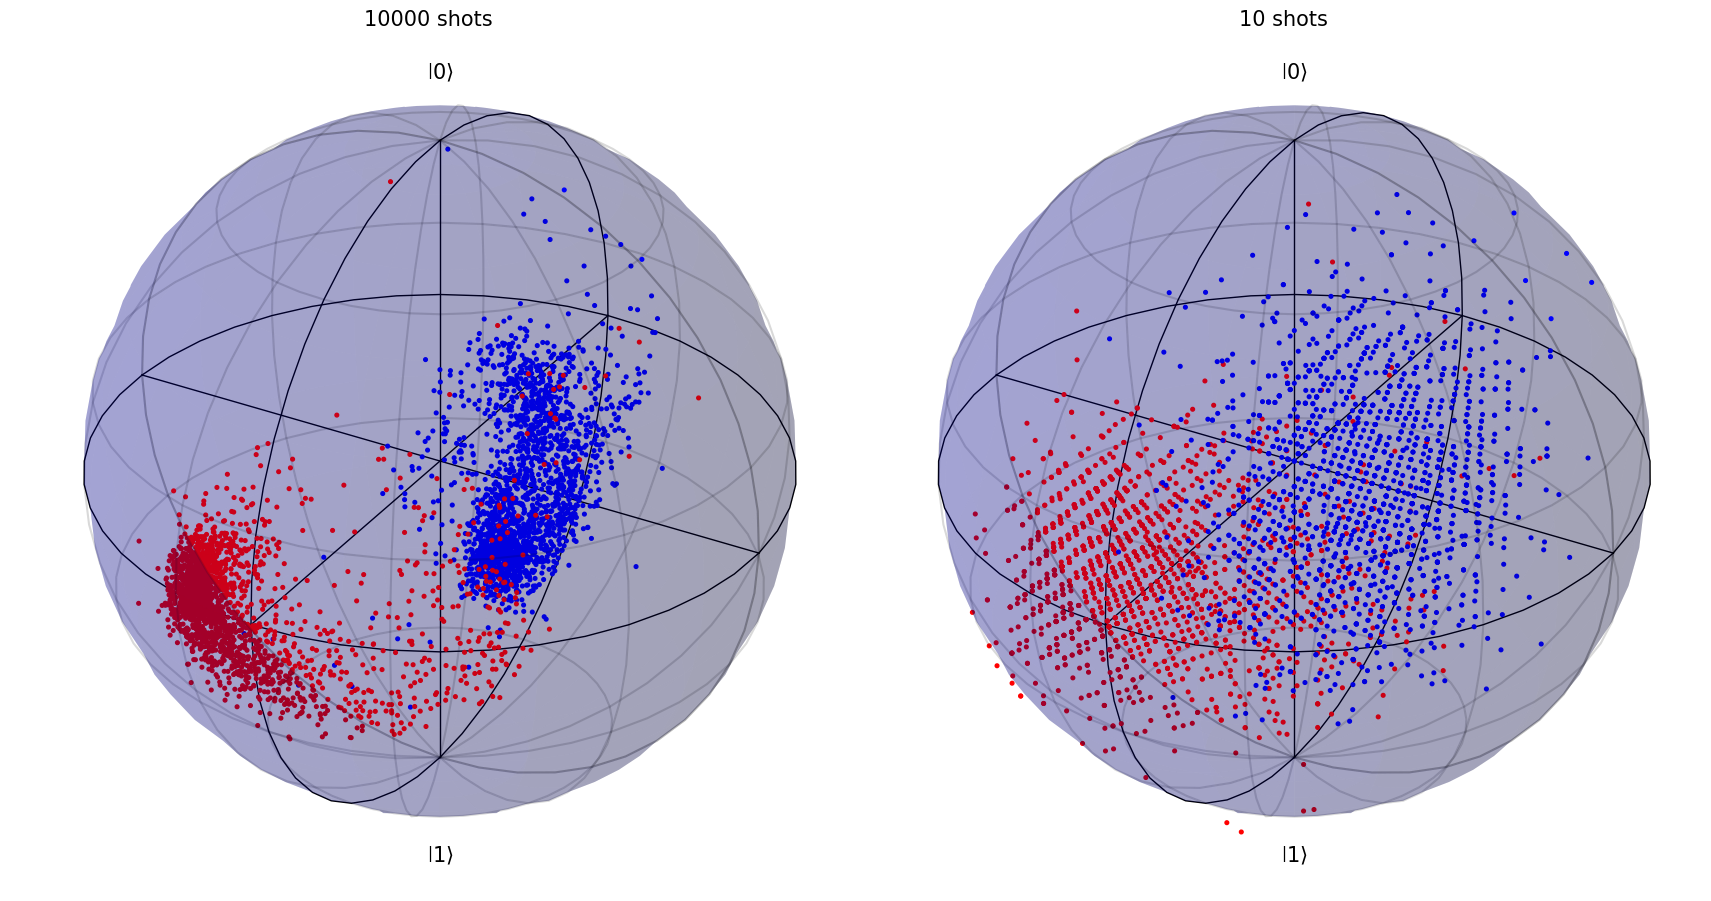

In [43]:
fig = plt.figure(figsize=(17,15),constrained_layout=True)
ax1 = fig.add_subplot(1, 2,1,  projection='3d')
b1= qutip.Bloch(fig=fig, axes=ax1)
b1.clear()
b1.font_color='k'
b1.frame_alpha=0.15
b1.sphere_alpha=0.2
b1.font_size=15
b1.sphere_color='darkblue'
b1.frame_color='k'
b1.point_size = [10,10]
b1.point_marker=['o','o'] 
b1.xlabel=['', '']
b1.ylabel=['', '']
b1.add_points([np.array(expX0_1).flatten(),np.array(expY0_1).flatten(),np.array(expZ0_1).flatten()])
b1.add_points([np.array(expX1_1).flatten(),np.array(expY1_1).flatten(),np.array(expZ1_1).flatten()])
#b1.point_color=['tab:blue','tab:orange']
#b1.view=[-10,10]
b1.zlpos = [1.2, -1.35]
b1.render()
ax1.set_title('10000 shots', fontsize=15,pad=20);
##########
###################
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
b2= qutip.Bloch(fig=fig, axes=ax2)
b2.clear()
b2.font_color='k'
b2.frame_alpha=0.15
b2.sphere_alpha=0.2
b2.font_size=15
b2.sphere_color='darkblue'
b2.frame_color='k'
b2.point_size = [10,10]
b2.point_marker=['o','o'] 
b2.xlabel=['', '']
b2.ylabel=['', '']
b2.add_points([np.array(expX0_2).flatten(),np.array(expY0_2).flatten(),np.array(expZ0_2).flatten()])
b2.add_points([np.array(expX1_2).flatten(),np.array(expY1_2).flatten(),np.array(expZ1_2).flatten()])
#b2.point_color=['tab:blue','tab:orange']
#b2.view=[-10,10]
b2.zlpos = [1.2, -1.35]
b2.render()
ax2.set_title('10 shots', fontsize=15,pad=20);
######################################
#ax3 = fig.add_subplot(1,3, 3, projection='3d')
#b3= qutip.Bloch(fig=fig, axes=ax3)
#b3.clear()
#b3.font_color='k'
#b3.frame_alpha=0.15
#b3.sphere_alpha=0.2
#b3.font_size=15
#b3.sphere_color='darkblue'
#b3.frame_color='k'
#b3.point_size = [7,7]
#b3.point_marker=['o','o'] 
#b3.xlabel=['', '']
#b3.ylabel=['', '']
#b3.add_points([np.array(expX0_3).flatten()/1.35,np.array(expY0_3).flatten()/1.35,np.array(expZ0_3).flatten()/1.35])
#b3.add_points([np.array(expX1_3).flatten()/1.35,np.array(expY1_3).flatten()/1.35,np.array(expZ1_3).flatten()/1.35])

#b3.point_color=['tab:blue','tab:orange']
#b3.view=[-10,10]
#b3.zlpos = [1.2, -1.35]
#b3.render()
#ax3.set_title('Third Qubit', fontsize=15,pad=20);


In [69]:
latent_dim = 2  # Dimension of the latent space

# Encoder network
def build_encoder(input_dim, latent_dim):
    encoder_inputs = tf.keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(encoder_inputs)
    x = layers.Dense(32, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder , z

# Decoder network
def build_decoder(latent_dim, output_dim):
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(decoder_inputs)
    x = layers.Dense(64, activation='relu')(x)
    decoder_outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    return decoder

# Full VAE model
def build_vae(encoder, decoder):
    encoder_inputs = encoder.input
    z_mean, z_log_var, z = encoder(encoder_inputs)
    reconstructed = decoder(z)
    
    def vae_loss(true, pred):
        reconstruction_loss = tf.reduce_mean(tf.square(true - pred))
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        return reconstruction_loss + kl_loss
    
    vae = tf.keras.Model(encoder_inputs, reconstructed)
    vae.add_loss(vae_loss(encoder_inputs, reconstructed))
    return vae

In [82]:
# Build and compile VAE
input_dim=3
encoder_model,z = build_encoder(input_dim, latent_dim)
decoder_model = build_decoder(latent_dim, input_dim)

outputs = decoder_model(encoder_model(input_dim))
#VAE = Model(encoder_input,outputs,name='VAE')
#vae.compile(optimizer=tf.keras.optimizers.Adam())

TypeError: cannot unpack non-iterable Functional object

# Test the network perfromance

In [51]:
def fidelity(train_1,train_2,x,W):
    n1 = NearestNeighbors(n_neighbors=1000)
    n2 = NearestNeighbors(n_neighbors=1000)
    n1.fit(train_1)
    n2.fit(train_2)
    d1,d2,d3 = qubit_embed(x,W)
    data = np.vstack((d1,d2,d3)).T
    fid = np.array(n1.kneighbors(data))[0,:,0] - np.array(n2.kneighbors(data))[0,:,0]
    return fid

In [60]:
train2 = np.vstack((expX0_1,expY0_1,expZ0_1)).T
train1 = np.vstack((expX1_1,expY1_1,expZ1_1)).T

In [66]:
#fpr_ = fidelity(train1,train2,X_test[Y_test==1][:500],W_new)
#tpr_ = fidelity(train1,train2,X_test[Y_test==-1][:500],W_new)

fpr_ = fidelity(train1,train2,x_test[1000:2000],W_new)
tpr_ = fidelity(train1,train2,x_test[1000:2000],W_new)

0it [00:00, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by NearestNeighbors.

In [62]:
fpr_ = (2*fpr_)-1
tpr_ = (2*tpr_)-1
pred = np.concatenate((fpr_,tpr_))
y_true = np.concatenate((np.ones(len(fpr_)),np.zeros(len(tpr_))))

In [63]:
fpr, tpr, thresholds = roc_curve(y_true,pred )
from sklearn import metrics
AUC = metrics.auc(tpr, fpr)
AUC

0.9578015000000001

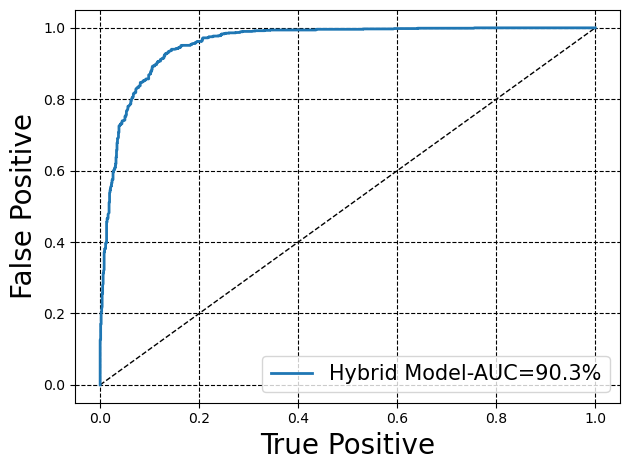

In [64]:
plt.plot([0,1],[0,1],'k--',linewidth=1);
plt.plot(tpr,fpr,linewidth=2,label='Hybrid Model-AUC=90.3%');
plt.grid(linestyle='--',c='k');
plt.legend(fontsize=15);
plt.xlabel('True Positive',fontsize=20);
plt.ylabel('False Positive',fontsize=20);
plt.tight_layout();
